# COVID Early Warning System Project Overview

Project goals, tools and techniques used, and data source info can be found [here](https://github.com/salvir1/covid-early-warning-system)

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [16]:
# Load in the COVID Tracking Project dataset by date and by state for US
covidtracking = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv")

# covidtracking.columns

In [17]:
df_state = covidtracking[['date', 'state', 'fips','positiveIncrease', 'deathIncrease', 'negativeIncrease']]
# df_state.info()

df_state['date'] = pd.to_datetime(df_state['date'], format='%Y%m%d')
df_state = df_state[df_state['date'] >= '2020-03-10']
df_state = df_state.sort_values('date', ascending=True)

# df_state.state.unique()

In [18]:
# Load in state population counts and merge with ctp data
st_population = pd.read_csv('../data/state_abbrev.csv', thousands=',') 
df_state = df_state.merge(st_population, how='inner' ,left_on='state', right_on='Code')
df_state.isna().sum() # No missing values!

date                0
state               0
fips                0
positiveIncrease    0
deathIncrease       0
negativeIncrease    0
State               0
Code                0
Population          0
CVD_group           0
dtype: int64

In [19]:
# Create state groupings (currently a manual process based on death rates over certain time periods)

grouped_cvd = df_state.groupby(['CVD_group', 'date']).sum().reset_index()
grouped_cvd = grouped_cvd.drop('Population', axis=1)

group_population = st_population.groupby('CVD_group').sum().reset_index()
grouped_cvd = grouped_cvd.merge(group_population, on='CVD_group')
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'No outbreak' if x == 0 else x)
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'Spring outbreak' if x == 1 else x)
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'Summer outbreak' if x == 2 else x)
grouped_cvd['CVD_group'] = grouped_cvd['CVD_group'].apply(lambda x: 'Fall outbreak' if x == 3 else x)

In [20]:
# Calculate simple moving averages of the case counts and death counts.
case_SMA = []
death_SMA = []
negatives_SMA = []
for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
    case_SMA.append(group_df.iloc[:,3].rolling(window=14).mean())
    death_SMA.append(group_df.iloc[:,4].rolling(window=14).mean())
    negatives_SMA.append(group_df.iloc[:,5].rolling(window=14).mean())
grouped_cvd['case_SMA']= pd.concat(case_SMA)
grouped_cvd['death_SMA']= pd.concat(death_SMA)
grouped_cvd['negatives_SMA']= pd.concat(negatives_SMA)

In [21]:
print(group_population)

   CVD_group  Population
0          0   130279859
1          1    89770981
2          2    89126756
3          3    19061927


In [22]:
# Create a table to analyze the summer outbreak
# How many extra deaths occurred as a result of the summer outbreak? 
# Calc = sum of actual deaths from COVID in the summer outbreak group
# minus the expected deaths from COVID based on 'no outbreak' death rate
summer_outbreak_table = (grouped_cvd[(grouped_cvd['CVD_group'].isin(['No outbreak', 'Summer outbreak']) 
                                      & (grouped_cvd['date'] >= '2020-07-05') 
                                      & (grouped_cvd['date'] <= '2020-10-01'))])
summer_group_actual_deaths = summer_outbreak_table[summer_outbreak_table['CVD_group']=='Summer outbreak']['deathIncrease'].sum()
summer_group_expected_deaths = (summer_outbreak_table[summer_outbreak_table['CVD_group']=='No outbreak']['deathIncrease'].sum() 
                                / summer_outbreak_table[summer_outbreak_table['CVD_group']=='No outbreak']['Population'].iloc[0] 
                                * summer_outbreak_table[summer_outbreak_table['CVD_group']=='Summer outbreak']['Population'].iloc[0])
summer_group_excess_deaths = summer_group_actual_deaths  - summer_group_expected_deaths
summer_group_excess_deaths

25452.009032217327

In [23]:
summer_outbreak_table.head(1)

,CVD_group,date,fips,positiveIncrease,deathIncrease,negativeIncrease,Population,case_SMA,death_SMA,negatives_SMA
117,No outbreak,2020-07-05,650,15480,50,253815,130279859,14060.214286,157.5,223738.5


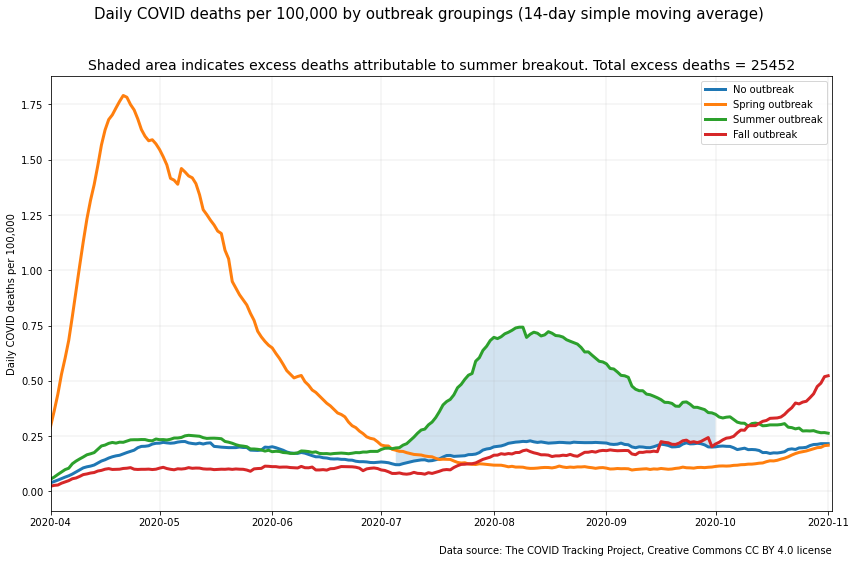

In [24]:
# Deaths per 100,000 by group over time
fig, ax = plt.subplots(figsize = (14,8))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.suptitle(f'Daily COVID deaths per 100,000 by outbreak groupings (14-day simple moving average)', size=15, y=1)
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
    ax.plot(group_df['date'], group_df['death_SMA'] / group_df['Population'] * 100000, label = chart_group, lw=3) 

ax.set_title(f'Shaded area indicates excess deaths attributable to summer breakout. Total excess deaths = {summer_group_excess_deaths:.0f}', size=14)
ax.set_ylabel('Daily COVID deaths per 100,000')
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.fill_between(pd.date_range(datetime.date(2020, 7, 5),datetime.date(2020, 10, 1),freq='d'),
                summer_outbreak_table[summer_outbreak_table['CVD_group']=='Summer outbreak']['death_SMA'] / 
                summer_outbreak_table[summer_outbreak_table['CVD_group']=='Summer outbreak']['Population'].iloc[0] * 100000,
                summer_outbreak_table[summer_outbreak_table['CVD_group']=='No outbreak']['death_SMA'] / 
                summer_outbreak_table[summer_outbreak_table['CVD_group']=='No outbreak']['Population'].iloc[0] * 100000,
                alpha = 0.2 )
ax.legend()
plt.savefig('img/COVID-deaths-by-outbreak-groupings.png')

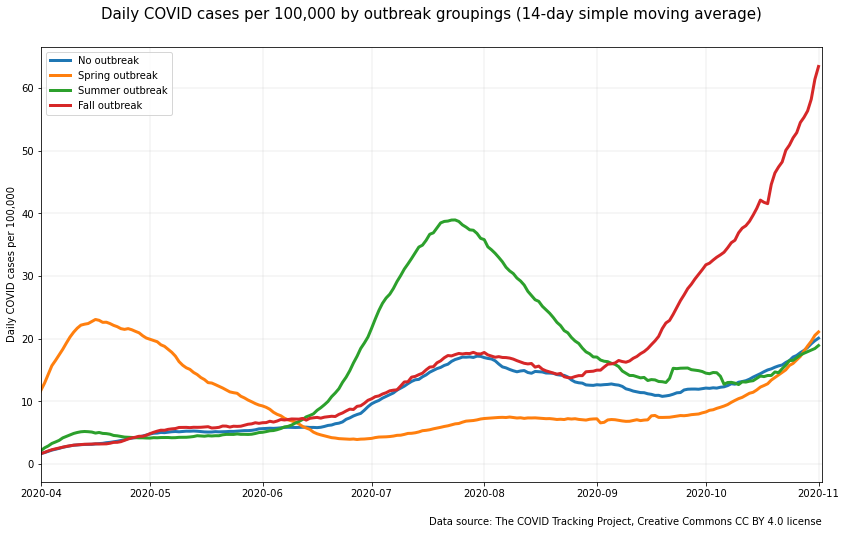

In [25]:
# Cases per 100,000 by group over time
fig, ax = plt.subplots(figsize = (14,8))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
#     ax.bar(group_df['date'], group_df['positiveIncrease'] / group_df['Population'] * 100000, label = f'{chart_group} actuals',  alpha=0.25)
    ax.plot(group_df['date'], group_df['case_SMA'] / group_df['Population'] * 100000, label = chart_group, lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.set_title(f'Daily COVID cases per 100,000 by outbreak groupings (14-day simple moving average)', size=15, y=1.05)
ax.set_ylabel('Daily COVID cases per 100,000')
ax.legend()

plt.savefig('img/COVID-cases-by-outbreak-groupings.png')

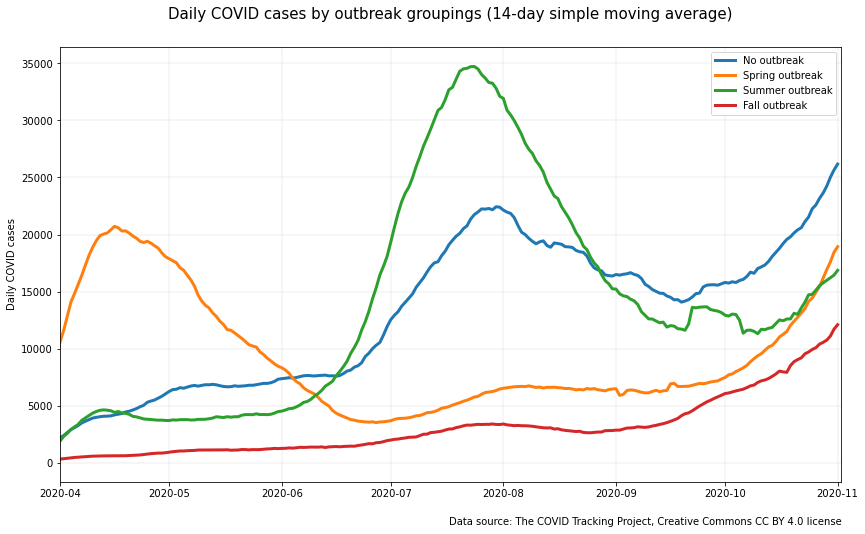

In [26]:
# Cases by group over time
fig, ax = plt.subplots(figsize = (14,8))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
#     ax.bar(group_df['date'], group_df['positiveIncrease'], label = f'{chart_group} actuals', alpha=0.25)
    ax.plot(group_df['date'], group_df['case_SMA'], label = chart_group, lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.set_title(f'Daily COVID cases by outbreak groupings (14-day simple moving average)', size=15, y=1.05)
ax.set_ylabel('Daily COVID cases')
ax.legend()

plt.savefig('img/COVID-total-cases-by-outbreak-groupings.png')

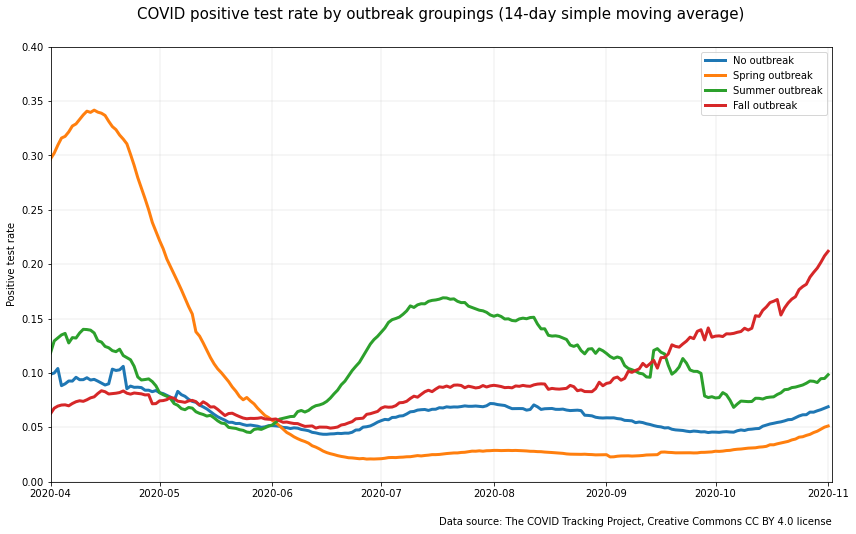

In [27]:
# Positivity rates by group over time
fig, ax = plt.subplots(figsize = (14,8))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
#     ax.bar(group_df['date'], group_df['positiveIncrease'] / (group_df['positiveIncrease'] + group_df['negativeIncrease']), label = f'{chart_group} actuals',  alpha=0.25)
    ax.plot(group_df['date'], group_df['case_SMA'] / (group_df['case_SMA'] + group_df['negatives_SMA']), label = chart_group, lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.set_ylim(0, 0.4)
ax.set_title(f'COVID positive test rate by outbreak groupings (14-day simple moving average)', size=15, y=1.05)
ax.set_ylabel('Positive test rate')
ax.legend()

plt.savefig('img/COVID-positive-test-rate-by-outbreak-groupings.png')

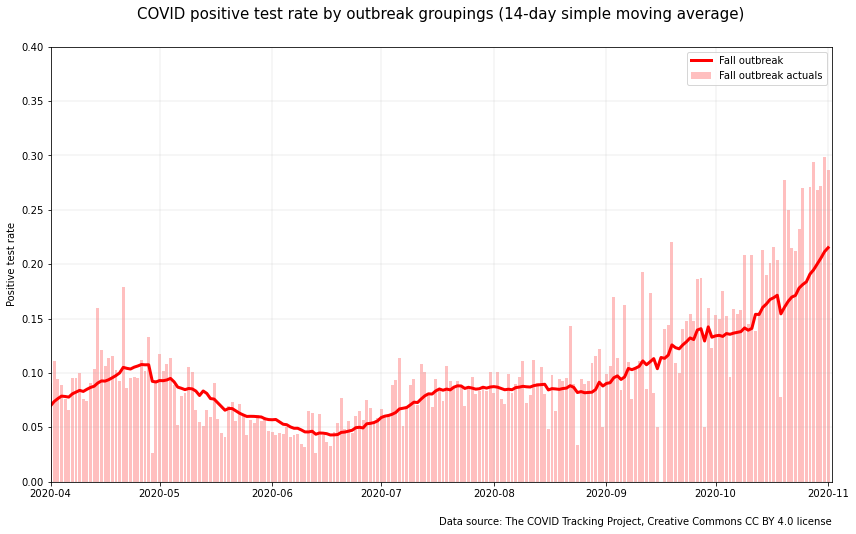

In [14]:
# Positivity rates by group over time
fig, ax = plt.subplots(figsize = (14,8))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    if chart_group == 'Fall outbreak':
        group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
        ax.bar(group_df['date'], group_df['positiveIncrease'] / (group_df['positiveIncrease'] + group_df['negativeIncrease']), label = f'{chart_group} actuals',  color = 'red', alpha=0.25)
        ax.plot(group_df['date'], group_df['case_SMA'] / (group_df['case_SMA'] + group_df['negatives_SMA']), color = 'red', label = chart_group, lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.set_ylim(0, 0.4)
ax.set_title(f'COVID positive test rate by outbreak groupings (14-day simple moving average)', size=15, y=1.05)
ax.set_ylabel('Positive test rate')
ax.legend()

plt.savefig('img/COVID-positive-test-rate-by-outbreak-groupings-showing-daily-variability.png')

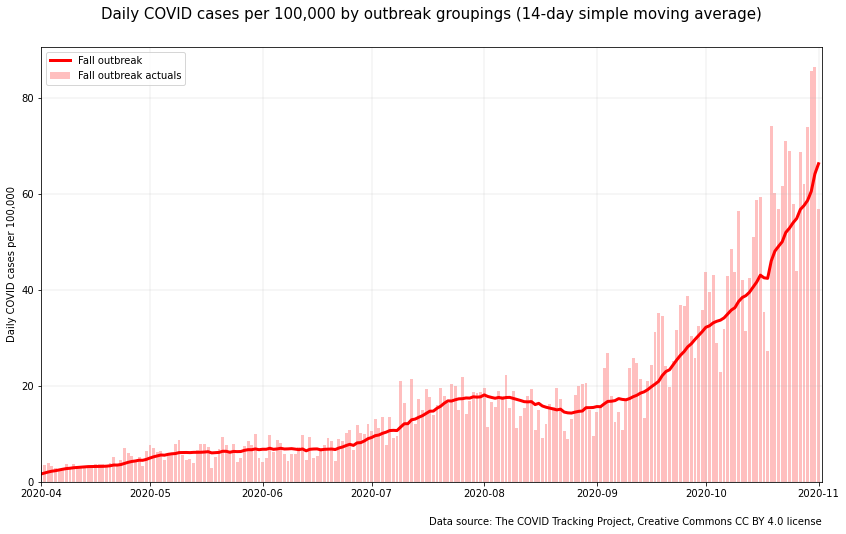

In [15]:
# Cases per 100,000 by group over time
fig, ax = plt.subplots(figsize = (14,8))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    if chart_group == 'Fall outbreak':
        group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
        ax.bar(group_df['date'], group_df['positiveIncrease'] / group_df['Population'] * 100000, label = f'{chart_group} actuals', color = 'red',  alpha=0.25)
        ax.plot(group_df['date'], group_df['case_SMA'] / group_df['Population'] * 100000, label = chart_group,color = 'red',  lw=3)
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.set_title(f'Daily COVID cases per 100,000 by outbreak groupings (14-day simple moving average)', size=15, y=1.05)
ax.set_ylabel('Daily COVID cases per 100,000')
ax.legend()

plt.savefig('img/COVID-cases-by-outbreak-groupings-showing-daily-variability.png')

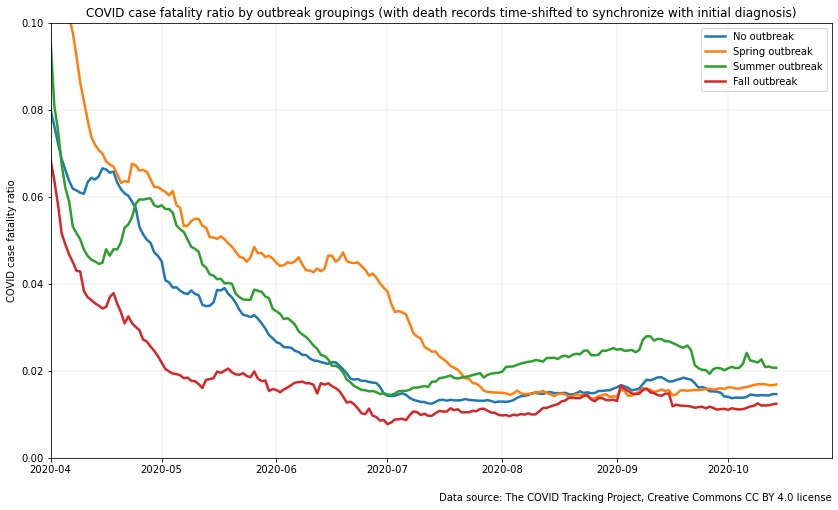

In [16]:
# Case fatality ratio by outbreak group over time
fig, ax = plt.subplots(figsize = (14,8))
plt.figtext(0.9, 0.05, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.grid(True, lw=0.2)

for chart_group in grouped_cvd['CVD_group'].unique():
    group_df = grouped_cvd[grouped_cvd['CVD_group']== chart_group]
    temp_group_df = group_df[['date', 'death_SMA']]
    temp_group_df['date'] = temp_group_df['date'] - timedelta(days=14) # shifting death records by 14 days to sync with cases
    group_df = group_df.merge(temp_group_df, on='date')
    ax.plot(group_df['date'], group_df['death_SMA_y'] / group_df['case_SMA'], label = chart_group, lw=2.5)

ax.set_ylabel('COVID case fatality ratio')
ax.set_xlim([datetime.date(2020, 4, 1), datetime.date.today()])
ax.set_ylim(0, 0.1)
ax.set_title(f'COVID case fatality ratio by outbreak groupings (with death records time-shifted to synchronize with initial diagnosis)')
ax.legend()
plt.savefig('img/COVID-case-fatality-by-outbreak-groupings.png')

### Creating state groupings helps to bring important trends to light

As the COVID-19 epidemic unfolded in the US over the course of 2020, outbreaks came in waves. These waves were not uniform across the country. Rather, each of the three distinct identifiable waves had its own unique geographic distribution. Most states, thankfully, only experienced one wave. Many others avoided severe outbreaks altogether. For those that had an outbreak, they were costly in terms of lives lost. By grouping states together according to outbreak--and a fourth group of states that did not experience an outbreak--one can see these outbreaks clearly, and also see just how costly these outbreaks were. 

The four charts below illustrate the outbreaks in different ways. The upper left chart shows daily deaths per 100,000 people for the four different groupings. The upper right chart shows daily new case diagnoses per 100,000 for the same groupings. The lower left chart shows the total new diagnoses made per day. Finally, the lower right chart shows the positive test rate per day. [Click here](###how-closely-do-the-covid-tracking-metrics-being-used-today-correlate-with-outbreaks) for larger versions of these charts.

<p float="left">
 <img src="img/COVID-deaths-by-outbreak-groupings.png" style="width:49%">
 <img src="img/COVID-cases-by-outbreak-groupings.png" style="width:49%">
</p>

The chart of death rates shows that states with outbreaks experienced death rates that were many times worse than states with no outbreak over the same time period. The baseline daily death rate stayed below 0.25 per 100,000 if no outbreak was occurring. Death rates were three or more times higher for groupings that were experiencing an outbreak. The cost of an outbreak in terms of lives lost can be extrapolated by comparing the elevated death rate of an outbreak to baseline. For example, the states that experienced a summer outbreak had over 25,000 more deaths above baseline. Outbreak avoidance saves lives.

The chart of case rates shows a shared baseline among groups that weren't experiencing an outbreak. The baseline rose a bit over the summer. Much of it might be attributable to the vastly expanded testing availability that occurred during that period and allowed for more cases to be diagnosed--There was little change in death rate over the summer for the groups that didn't experience an outbreak. The case rate trendlines also reveal a series of outbreaks that emerged quickly and rose steeply. The implicit message in the sharpness of the outbreak curves is that time is critical to containing an outbreak. 

It's informative to compare the trendlines between the two charts. As one would expect, the peaks of the case rate trendlines happen earlier than the peaks of the death rate trendlines. What is less expected is the differences in their relative sizes. Fortunately, the peak of the summer outbreak death rate was less than half the size as that of the spring outbreak, while the corresponding case rate peak was almost twice as large for the summer outbreak as it was for the spring outbreak. A likely explanation for some of the difference in death rates is that the medical community learned how to take better care of COVID patients over time. It's also likely that people who were most at risk to adverse outcomes from COVID were infected at lower rates in those places that experienced a summer outbreak than they were in locations that experienced a spring outbreak. It could be that we've not only learned how to take better care of COVID patients, but that we've also improved our ability to keep the most vulnerable of us from getting infected with COVID in the first place.

It's also informative to compare the height of the peaks of the death rate and case rate for the summer peak (and also for the fall although that story has not yet fully played out). The change in testing availability muddies things up a bit, but visually it appears as if the change in height of the case rate surpasses the change in height of the death rate. In other words, infection rates may have expanded more than death rates. This is plausible when one considers that neither transmission rates nor risk of adverse outcomes are uniform across a population. Taking the transmission rates first, transmission occurs through proximite human-to-human contact. One would expect people with higher contact rates to have higher rates of infection. *Indeed, one would expect the spread of COVID virus to be dependent upon those of us with higher contact rates.* Now, taking adverse outcomes into account, certain subsets of the population have much higher risk of death than others. Seventy-nine percent of COVID deaths in the US occurred in [people older than 65](https://www.cdc.gov/nchs/nvss/vsrr/covid_weekly/index.htm). Continued emphasis must be on reducing transmission to this population. This knowledge could be used as the foundation for a targeted COVID surveillance system. We could monitor COVID infection rates among the most mobile of us where an outbreak will start to form first as one key element in a strategy to minimize transmission to the most vulnerable of us.

(How were these groupings made? For this analysis, states were grouped into one of four categories based upon season and severity of an outbreak in terms of daily deaths reported per 100,000. An outbreak was defined at the state level according to criteria desribed in the states analysis section. When rolled up to the state grouping level, the daily death rate exceeded 0.25 per 100,000 population for an outbreak. Outbreaks for the spring, summer, and fall began prior to 4/1/20, 7/1/20, and 10/1/20 respectively.)

### How closely do the COVID tracking metrics being used today correlate with outbreaks?

<img align="center" src="img/COVID-deaths-by-outbreak-groupings.png" width='1000' height='auto' ></img>

Governments and public health agencies are unlikely to drive the death rate down to zero until a vaccine is available, but they can work to avoid an outbreak to avoid the associated costs of lives lost. Clearly, timing is important. By the time death rates start to increase, an outbreak has been many weeks in the making. While the death rate may be the most direct measure of the cost of the pandemic, it's a lagging indicator. Governments and public health agencies need an early warning system--a leading indicator or indicators--in order to have the best chance at keeping the rate of infections, and thus deaths, under control in their jurisdictions. Various measures are used today to monitor the new infection rate of COVID in order to help states manage the disease.

- Total cases (i.e. new diagnoses)
- Case rate (a version of total cases normalized by dividing by population)
- Positive test rate (cases per population)

Prior to determining their utility as early warning indicators, the first step is to determine how closely they correlate with outbreaks? Do they provide a clear signal? Charts of the trendlines (using 14-day moving averages) for these measures were applied to the state groupings defined above for the time period 4/1/20 and forward in order to determine their utility at indicating an outbreak.

- The case rate per 100,000 provided the clearest signal of an outbreak occurring. 
- The chart of total cases has several shortcomings that limit its ability to predict an outbreak.
- The positive test rate signal is noisier than the others.

Let's look at these metrics in turn.

<img align="center" src="img/COVID-cases-by-outbreak-groupings.png" width='1000' height='auto' ></img>

The *case rate* chart reveals a number of interesting patterns.

- While the *spring outbreak* was occurring, the infection rate was uniform among the other groups.
- The *summer outbreak* emerged quickly. The *fall outbreak* group and *no outbreak* group maintained comparable infection rates even as the the rates crept up (perhaps due to states easing restrictions en masse). The reported infection rate for the *summer outbreak* group suprassed that of the *spring outbreak*. This could be explained in part by increased testing.
- The *fall outbreak* ramped up quickly as well. It appears to be headed towards a higher peak than either of the two previous outbreaks. Fortunately, this outbreak is affecting a much smaller portion of the US population than the previous two at this time.
- The rapid ramp-ups of the summer and fall outbreaks suggest an early warning system may be necessary to *see* an emerging outbreak before its too late. By the time the trends start to change in the case rate data it may be too late to avoid an outbreak. 
- The peaks for the three different outbreaks get larger over time. This mirrors testing availability, which points to a major shortcoming of the COVID surveillance systems that states are using today. Longitudinal comparisons of case counts or case rates are muddied by the fact that testing has become more widespread over time. Some public officials have dismissed rising case counts as simply a result of more testing, but the outbreaks identified in this analysis correspond to the one metric that truly matters--sharply rising death rates.

<img align="center" src="img/COVID-total-cases-by-outbreak-groupings.png" width='1000' height='auto' ></img>

The chart of *total cases diagnosed per day* wasn't as clean of an indicator of an outbreak. Over the summer, the trendline of total cases diagnosed in the *no outbreak* group rose almost as much as the trendline for the *summer outbreak* group. All trendlines rose heading into the fall even though the outbreak for the *fall outbreak* group has thus far been more severe. The normalization that occurs in the *case rate* chart appears to be beneficial in sorting out the true signal. 

<img align="center" src="img/COVID-positive-test-rate-by-outbreak-groupings.png" width='1000' height='auto' ></img>

The *positive test rate* chart provides a signal that correlates with the deaths chart, but it isn't as pronounced as the case rate trendline. Also, this signal appears more noisy than the others, which can add undesirable delay. Further exploration of the issue of noise in the signal happens later in this project.

